# Reddit Sentiment Analysis

Project by [Salomé NKB](LINKEDIN.COM/IN/SALOME28) (@Salome28), [Marta Fonseca](LINKEDIN.COM/IN/MCRFONSECA) (@Martacrf), [Taylor Shook](LINKEDIN.COM/IN/TAYLORSHOOK) (@Taylorshook1).

### Exploration of sentiment trends and key discussion topics across multiple subreddits using Natural Language Processing, comparing data from 2019 to the present.

### **Key question: Are people angrier these days ?**
Determine the tendency of negative feelings among people in the world by analyzing the sentiment of comments on Reddit. We will compare comments from 2019 to those from the present across 40 subreddits. Our aim is to identify whether comments have become more negative or positive over time and uncover the key words frequently used in discussions.

### **Key areas of analysis:**
- Sentiment Trends: Analyze whether there is an observable trend in the sentiment of Reddit comments over time. Are comments becoming more negative or positive? </br>
- Topic Identification: Discover what people are talking about in various subreddits by identifying common themes and topics.</br>
- Frequent Words: Determine the most frequently occurring words in comments to understand the general sentiment and topics of discussion.</br>
- General Sentiment: Assess the overall sentiment distribution of comments to see if they are predominantly positive or negative.</br>

### Sentiments

For these particular analysis we wanted to focus on 7 emotions : 

- Joy
- Sadness
- Fear
- Disgust
- Neutral
- Anger
- Surprise

##### Data Source:
We are using two main data sources:
- [Dataset containing 1 million Reddit comments from 40 subreddits collected in 2019](https://www.kaggle.com/datasets/smagnan/1-million-reddit-comments-from-40-subreddits?resource=download) </br>
- Comments retrieved from the same 40 subreddits using the Reddit API, focusing on the most recent data available.
</br>


## Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import torch
from textblob import TextBlob
from transformers import AutoTokenizer, AutoModelForSequenceClassification


#Warnings
import warnings
warnings.filterwarnings('ignore')

/Users/salomenkb/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Importing the datasets

In [2]:
#File 1
file_path1 = 'kaggle_RC_2019-05.csv'
dataset1 = pd.read_csv(file_path1)
dataset1.head()

,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3
3,news,You know we have laws against that currently c...,0,10
4,politics,"Yes, there is a difference between gentle supp...",0,1


In [3]:
#file path 2
file_path2 = 'comment_data.jsonl'

dataset2 = pd.read_json(file_path2, lines=True)
dataset2.head()

,body,author,title,created_utc,subreddit
0,"Cool action, but I hate characters that make d...",bisteot,/r/gameofthrones/comments/1dxvysp/hotd_s2e4_li...,1720454338,gameofthrones
1,**Spoiler Warning:** All officially-released s...,AutoModerator,/r/gameofthrones/comments/1dxvysp/hotd_s2e4_li...,1720400110,gameofthrones
2,They put it up early!,Kingokie12,/r/gameofthrones/comments/1dxvysp/hotd_s2e4_li...,1720400390,gameofthrones
3,They're preparing this is to be the best episo...,kursedten513,/r/gameofthrones/comments/1dxvysp/hotd_s2e4_li...,1720401173,gameofthrones
4,i got a feeling this episode is gonna be one o...,LilBottomText17,/r/gameofthrones/comments/1dxvysp/hotd_s2e4_li...,1720400458,gameofthrones


In [4]:
print(f"Dataset 1 has {len(dataset1)} comments")
print(f"Dataset 2 has {len(dataset2)} comments")

Dataset 1 has 1000000 comments
Dataset 2 has 1033905 comments


In [5]:
#Identify duplicated
print(f"There are {len(dataset1[dataset1.duplicated()])} duplicated rows")
print(f"There are {len(dataset2[dataset2.duplicated()])} duplicated rows")

There are 22011 duplicated rows
There are 756081 duplicated rows


## Merging the datasets

#### Merging the data sets and add a new Column "Year" to identify the rows

In [6]:
# Add a new column 'year' with specified values
dataset1['year'] = 2019
dataset2['year'] = 2024

# Merge the dataframes
dataset = pd.concat([dataset1, dataset2], ignore_index=True)
dataset.reset_index(drop=True, inplace=True)

# Display the merged dataframe
dataset.tail()

,subreddit,body,controversiality,score,year,author,title,created_utc
2033900,Showerthoughts,Seeing what others do is the key to success. S...,NaN,NaN,2024,Flat-Zookeepergame32,/r/Showerthoughts/comments/1e1yu0d/when_people...,1.720841e+09
2033901,Showerthoughts,How is your critique anybetter ? They obviousl...,NaN,NaN,2024,Transfiguredbet,/r/Showerthoughts/comments/1e1yu0d/when_people...,1.720845e+09
2033902,Showerthoughts,"You can compare yourself above and beyond, and...",NaN,NaN,2024,Flat-Zookeepergame32,/r/Showerthoughts/comments/1e1yu0d/when_people...,1.720845e+09
2033903,Showerthoughts,"Yes you can accept your limitations, so you ma...",NaN,NaN,2024,Transfiguredbet,/r/Showerthoughts/comments/1e1yu0d/when_people...,1.720846e+09
2033904,Showerthoughts,You need external comparisons. You're not omni...,NaN,NaN,2024,Flat-Zookeepergame32,/r/Showerthoughts/comments/1e1yu0d/when_people...,1.720846e+09


## Cleaning the dataset

### Get to know the data

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033905 entries, 0 to 2033904
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   subreddit         object 
 1   body              object 
 2   controversiality  float64
 3   score             float64
 4   year              int64  
 5   author            object 
 6   title             object 
 7   created_utc       float64
dtypes: float64(3), int64(1), object(4)
memory usage: 124.1+ MB


In [8]:
# Subreditts
dataset['subreddit'].value_counts()

subreddit
AskReddit              99862
politics               98230
AmItheAsshole          94288
nba                    79615
news                   79162
worldnews              73219
relationship_advice    70273
gaming                 66856
SquaredCircle          66094
pics                   57619
soccer                 55705
gameofthrones          53770
nfl                    52888
todayilearned          52762
trashy                 50203
leagueoflegends        49849
movies                 49066
teenagers              48622
RoastMe                48358
hockey                 46213
FortNiteBR             42523
Showerthoughts         42316
memes                  41728
wallstreetbets         41569
unpopularopinion       41068
funny                  41020
marvelstudios          40678
aww                    40489
asoiaf                 40114
freefolk               39556
dankmemes              39382
gonewild               38284
videos                 36958
Market76               36379
apex

### Remove non necessary subreddits

We decided to keep 8 subreddits that could perhaps reveal new tendencies in the users' behaviors. 

- **'AskReddit'** : one the most popular subreddit where differen subjects are discussed so we would probably have higher chances of capturing new trends or changes.

- **'AmItheAsshole'** : Another very popular subreddit about people's personal lives and interactions with one another, seemed like a great place for all sorts of sentiments

- **'Politics'** : as politics often start interesting conversations among peers but also divide people it is also a nice place to witness the general sentiment of the people

- **'Relationship_advice'** : All the drama of one's relationship can sparkle quite a few reactions

- **'Worldnews'** : it's the same as politics, with the latest events in the world it appears even more relevant to analyse this subreddit

- **'News'** : same as worldnews but perhaps more likely to have happier news therefore more happy comments

- **'TodayIlearned' and 'Showerthoughts'** : both subreddits seemed 'innocent' and friendly that we decided we could perhaps have a better vision of all the different sentiments 

In [9]:
#The subreddit Pikabu is a russian subreddit, so we can delete it
dataset = dataset[dataset['subreddit'] != 'Pikabu']

#Delete other subreddits:
subreddits_to_keep = [
    'AskReddit', 'AmItheAsshole', 'politics', 'relationship_advice', 'worldnews','news','todayIlearned','Showerthoughts']

dataset = dataset[dataset['subreddit'].isin(subreddits_to_keep)]
dataset.shape

(557350, 8)

### Remove duplicates

In [10]:
dataset = dataset.drop_duplicates()
dataset.shape

(256802, 8)

### Remove columns

In [12]:
dataset.head()

,subreddit,body,controversiality,score,year,author,title,created_utc
3,news,You know we have laws against that currently c...,0.0,10.0,2019,NaN,NaN,NaN
4,politics,"Yes, there is a difference between gentle supp...",0.0,1.0,2019,NaN,NaN,NaN
6,relationship_advice,I would be less worried about how he fucked up...,0.0,7.0,2019,NaN,NaN,NaN
8,worldnews,How many millions have to suffer and die for t...,0.0,3.0,2019,NaN,NaN,NaN
10,AskReddit,Like a giant turd that feels like it's coming ...,0.0,2.0,2019,NaN,NaN,NaN


In [11]:
dataset = dataset[["subreddit", "body", "year"]]
dataset = dataset.reset_index(drop=True)
dataset.head()

,subreddit,body,year
0,news,You know we have laws against that currently c...,2019
1,politics,"Yes, there is a difference between gentle supp...",2019
2,relationship_advice,I would be less worried about how he fucked up...,2019
3,worldnews,How many millions have to suffer and die for t...,2019
4,AskReddit,Like a giant turd that feels like it's coming ...,2019


### Deleting the comments deleted or removed by Reddit but appeared as 'deleted' or 'removed'

In [12]:
dataset = dataset[dataset["body"] != "[deleted]"]
dataset = dataset[dataset["body"] != "[removed]"]

### Counting how many comments the datasets holds per year

In [13]:
dataset[dataset["year"] == 2019].count()

subreddit    170392
body         170392
year         170392
dtype: int64

In [14]:
dataset[dataset["year"] == 2024].count()

subreddit    85520
body         85520
year         85520
dtype: int64

## Large Language Model : BERT or Roberta ?

For our sentiment analysis, we decided to experiment with various models and training approaches to determine which would perform best. Due to time constraints, creating our own training dataset proved challenging. Given the large size of our dataset, it would be more practical to use a training set that is at least 1/10th the size of the full dataset to effectively train the LLM.

## DistilBERT

For our initial model, we used a training set with various emotions available on Hugging Face to train the model, and then applied our dataset as the test set. The emotions included in this dataset were anger, disgust, fear, joy, sadness, and surprise. Since the dataset lacked a neutral category, we used the 'TextBlob' library to identify and include neutral comments as well.

After labeling the comments with their respective emotions, the code generates a JSONL file that organizes all comments by emotion, facilitating easier analysis in subsequent steps.

In [ ]:
model_path = 'my_model/checkpoint-3000'

# Load the tokenizer and model from the checkpoint directory
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Adding 'neutral' to the emotion labels
emotion_labels = ['neutral', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

def is_neutral_textblob(comment, threshold=0.05):
    blob = TextBlob(comment)
    polarity = blob.sentiment.polarity
    return -threshold <= polarity <= threshold

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    return emotion_labels[predictions.item() + 1]  # +1 to account for 'neutral' at index 0

# Initialize a dictionary to hold the data for each emotion
emotion_data = {label: [] for label in emotion_labels}


# Filter and predict emotions for non-neutral comments
for index, row in dataset.iterrows():
    comment = row['body']
    if is_neutral_textblob(comment):
        emotion = 'neutral'
    else:
        emotion = predict_emotion(comment)

    # Append the relevant data to the corresponding emotion list
    emotion_data[emotion].append({
        'subreddit': row['subreddit'],
        'body': row['body'],
        'year': row['year']
    })

# Write each emotion data to its corresponding JSONL file
for emotion, entries in emotion_data.items():
    with open(f'{emotion}.jsonl', 'w') as outfile:
        for entry in entries:
            json.dump(entry, outfile)
            outfile.write('\n')

## DistilRoBERTa

For DistilRoBERTa, we used a different approach: thanks to the wonderful AI community at Hugging Face, we found a model that had already been trained data. According to the documentation the model was trained on datasets representing a diverse collection of text types. Specifically, they contain emotion labels for texts from Twitter, Reddit, student self-reports, and utterances from TV dialogues. It then seemed relevant to use it on our dataset.

All documentation on this particular model can be found [HERE](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)

In [ ]:
model_path = 'j-hartmann/emotion-english-distilroberta-base'

# Load the tokenizer and model from the checkpoint directory
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    return emotion_labels[predictions.item()]

# Initialize a dictionary to hold the data for each emotion
emotion_data = {}

# Iterate over the dataframe and predict the emotion for each body text
for index, row in dataset.iterrows():
    emotion = predict_emotion(row['body'])
    if emotion not in emotion_data:
        emotion_data[emotion] = []

    # Append the relevant data to the corresponding emotion list
    emotion_data[emotion].append({
        'subreddit': row['subreddit'],
        'body': row['body'],
        'year': row['year']
    })

# Write each emotion data to its corresponding JSONL file
for emotion, entries in emotion_data.items():
    with open(f'/content/drive/My Drive/RedditSentimentAnalysis/distilRoBERTa/{emotion}.jsonl', 'w') as outfile:
        for entry in entries:
            json.dump(entry, outfile)
            outfile.write('\n')

## Third model : DistilBERT 

The third approach involved selecting a small portion of the dataset, labeling it, training DistilBERT on it, and then testing the model on another small portion of our dataset. We aimed to refine the model by taking the best potential predictions and further training it. Unfortunately, this longer process still resulted in poor model performance.

When working on projects with LLMs, time management is both tricky and complex. It's crucial to plan ahead, choose the right strategy, and allocate sufficient time and resources. Given that our project spanned less than a month, we lacked the necessary time and resources to properly train this third model.

# Building the golden set

anger 🤬 disgust 🤢 fear 😨 joy 😀 neutral 😐 sadness 😭 surprise 😲

“A golden test set is a predetermined collection of test expressions or data points that are carefully curated by human experts. These test expressions represent a diverse range of inputs and cover various scenarios to evaluate the performance and effectiveness of different versions of an AI model.”

We selected specific comments and labeled them with an emotion to create a golden set, enabling us to evaluate the performance of our models.

### Anger

In [15]:
#dataset 2019
dataset_anger_2019 = dataset[(dataset['year']==2019) & (dataset['body'].str.contains('I hate this'))]

#dataset 2024
dataset_anger_2024 = dataset[(dataset['year']==2024) & (dataset['body'].str.contains('I hate this'))]

#concatenate anger datasets
golden_set_anger = pd.concat([dataset_anger_2019.loc[[94952, 103227, 58496]], dataset_anger_2024.loc[[171324, 176019, 177447]]])
golden_set_anger['emotion'] = 'anger'
golden_set_anger

,subreddit,body,year,emotion
94952,politics,"You know he won't, and Republicans dont care. ...",2019,anger
103227,politics,The PRESS is at fault now. Right. Not that you...,2019,anger
58496,news,Yeah I hate this narrative the oh it's conserv...,2019,anger
171324,news,Lol! In THIS political and warring state of th...,2024,anger
176019,politics,Every generation deserves some blame and some ...,2024,anger
177447,relationship_advice,I hate this suggestion. One of the key issues ...,2024,anger


### Disgust

In [16]:
#dataset 2019
dataset_disgust_2019 = dataset[(dataset['year']==2019) & (dataset['body'].str.contains('disgusting'))]

#dataset 2024
dataset_disgust_2024 = dataset[(dataset['year']==2024) & (dataset['body'].str.contains('disgusting'))]

#concatenate disgust datasets
golden_set_disgust = pd.concat([dataset_disgust_2019.loc[[169837, 14, 1162]], dataset_disgust_2024.loc[[170641, 173147, 180304]]])
golden_set_disgust['emotion'] = 'disgust'
golden_set_disgust

,subreddit,body,year,emotion
169837,relationship_advice,I would contact her family so they know what’s...,2019,disgust
14,news,This is disgusting every week,2019,disgust
1162,AmItheAsshole,These sick fucks are probably the same people ...,2019,disgust
170641,news,They hit the section where they treated childr...,2024,disgust
173147,news,I'm in the northeast and this has to be the gr...,2024,disgust
180304,worldnews,"Not just children, children going through chem...",2024,disgust


### Fear

In [17]:
#dataset 2019
dataset_fear_2019 = dataset[(dataset['year']==2019) & (dataset['body'].str.contains('fear'))]

#dataset 2024
dataset_fear_2024 = dataset[(dataset['year']==2024) & (dataset['body'].str.contains('fear'))]

golden_set_fear = pd.concat([dataset_fear_2019.loc[[152, 326, 1767]], dataset_fear_2024.loc[[171618, 171678, 173116]]])
golden_set_fear['emotion'] = 'fear'
golden_set_fear

,subreddit,body,year,emotion
152,AskReddit,I have always said that when my kids are grown...,2019,fear
326,AskReddit,"As a kid, my only fear was thin branches and e...",2019,fear
1767,AskReddit,This is my absolute worst fear. Being in your ...,2019,fear
171618,news,I fear that here in the UK the far right are r...,2024,fear
171678,news,"I think the French hurt the far right, but sti...",2024,fear
173116,news,I fear for everyone that is employed in indust...,2024,fear


### Joy

In [18]:
#dataset 2019
dataset_joy_2019 = dataset[(dataset['year']==2019) & (dataset['body'].str.contains("I'm so happy","Such a joy"))]

#dataset 2024
dataset_joy_2024 = dataset[(dataset['year']==2024) & (dataset['body'].str.contains("happy"))]

#concatenate joy datasets
golden_set_joy = pd.concat([dataset_joy_2019.loc[[2556, 150291, 165755]], dataset_joy_2024.loc[[172513, 182372, 179198]]])
golden_set_joy['emotion'] = 'joy'
golden_set_joy

,subreddit,body,year,emotion
2556,AskReddit,"My first snake... he is a corn snake, and I go...",2019,joy
150291,news,I'm so happy I'm not the only one. I literally...,2019,joy
165755,relationship_advice,"I'm so happy! I am glad to hear this, good luc...",2019,joy
172513,news,I'm so happy to be amongst my people. Got any ...,2024,joy
182372,worldnews,I don't understand French politics but im happ...,2024,joy
179198,relationship_advice,Congratulations and I'm happy your wedding (an...,2024,joy


### Neutral

In [19]:
#dataset 2019
dataset_neutral_2019 = dataset[(dataset['year']==2019) & (dataset['body'].str.contains("informing"))]

#dataset 2024
dataset_neutral_2024 = dataset[(dataset['year']==2024) & (dataset['body'].str.contains('information'))]

#concatenate neutral datasets
golden_set_neutral = pd.concat([dataset_neutral_2019.loc[[78936, 75418, 61811]], dataset_neutral_2024.loc[[170943, 192179, 170927]]])
golden_set_neutral['emotion'] = 'neutral'
golden_set_neutral

,subreddit,body,year,emotion
78936,worldnews,Thank you for informing us.,2019,neutral
75418,AmItheAsshole,"NTA, if there's any fallout with the family it...",2019,neutral
61811,politics,The strategy of consistently attacking Trump i...,2019,neutral
170943,news,So voters will know what causes mass shootings...,2024,neutral
192179,Showerthoughts,I created a board with digital memorial using ...,2024,neutral
170927,news,Democrats pass laws to prevent information lik...,2024,neutral


### Sadness

In [20]:
#dataset 2019
dataset_sadness_2019 = dataset[(dataset['year']==2019) & (dataset['body'].str.contains("I'm sad", "so sad"))]

#dataset 2024
dataset_sadness_2024 = dataset[(dataset['year']==2024) & (dataset['body'].str.contains("so sad"))]

#concatenate sadness datasets
golden_set_sadness = pd.concat([dataset_sadness_2019.loc[[19167, 135575, 14490]], dataset_sadness_2024.loc[[173760, 176669, 188111]]])
golden_set_sadness['emotion'] = 'sadness'
golden_set_sadness

,subreddit,body,year,emotion
19167,news,That's wild. I'm sad for everyone right now.,2019,sadness
135575,news,I'm sadden by reports and social media platfor...,2019,sadness
14490,AskReddit,Splatoon 2. I'm sad that I have to pay to play...,2019,sadness
173760,politics,It's so sad to see too. Trump regularly goes t...,2024,sadness
176669,relationship_advice,"Oh my word. This all made me so sad, and broug...",2024,sadness
188111,AmItheAsshole,I'm so sad now reading her comment expanding o...,2024,sadness


### Surprise

In [21]:
#dataset 2019
dataset_surprise_2019 = dataset[(dataset['year']==2019) & (dataset['body'].str.contains("Really?"))]

#dataset 2024
dataset_surprise_2024 = dataset[(dataset['year']==2024) & (dataset['body'].str.contains("Really?"))]

#concatenate surprise datasets
golden_set_surprise = pd.concat([dataset_surprise_2019.loc[[1341, 1384, 1458]], dataset_surprise_2024.loc[[191208, 188233, 181171]]])
golden_set_surprise['emotion'] = 'surprise'
golden_set_surprise

,subreddit,body,year,emotion
1341,politics,That’s your defense? Really?,2019,surprise
1384,AmItheAsshole,YTA. Really!?! Relax man it’s a normal aspect ...,2019,surprise
1458,news,Really? Why are they deleting these stories?,2019,surprise
191208,Showerthoughts,Really? Have you met 11-19 year olds?,2024,surprise
188233,AmItheAsshole,Really! What's wrong with stir fry? My partner...,2024,surprise
181171,worldnews,Really? They work the same way in my country a...,2024,surprise


### Concatenate all Emotions

anger 🤬
disgust 🤢
fear 😨
joy 😀
neutral 😐
sadness 😭
surprise 😲

In [22]:
golden_set = pd.concat([
    golden_set_anger,
    golden_set_disgust,
    golden_set_fear,
    golden_set_joy,
    golden_set_neutral,
    golden_set_sadness,
    golden_set_surprise
], ignore_index=True)

golden_set

,subreddit,body,year,emotion
0,politics,"You know he won't, and Republicans dont care. ...",2019,anger
1,politics,The PRESS is at fault now. Right. Not that you...,2019,anger
2,news,Yeah I hate this narrative the oh it's conserv...,2019,anger
3,news,Lol! In THIS political and warring state of th...,2024,anger
4,politics,Every generation deserves some blame and some ...,2024,anger
5,relationship_advice,I hate this suggestion. One of the key issues ...,2024,anger
6,relationship_advice,I would contact her family so they know what’s...,2019,disgust
7,news,This is disgusting every week,2019,disgust
8,AmItheAsshole,These sick fucks are probably the same people ...,2019,disgust
9,news,They hit the section where they treated childr...,2024,disgust


In [23]:
golden_set.value_counts('emotion')

emotion
anger       6
disgust     6
fear        6
joy         6
neutral     6
sadness     6
surprise    6
Name: count, dtype: int64

# Evaluating the models with our Golden set

## DistilRoberta

In [32]:
model_path = 'j-hartmann/emotion-english-distilroberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    return emotion_labels[predictions.item()]

# Add a new column 'BERT' to hold the predicted emotions
golden_set['RoBERTa'] = None

# Filter and predict emotions for each comment in the dataset
for index, row in golden_set.iterrows():
    comment = row['body']
    emotion = predict_emotion(comment)

    # Update the 'BERT' column with the predicted emotion
    golden_set.at[index, 'RoBERTa'] = emotion

golden_set

,subreddit,body,year,emotion,RoBERTa,BERT
0,politics,"You know he won't, and Republicans dont care. ...",2019,anger,anger,joy
1,politics,The PRESS is at fault now. Right. Not that you...,2019,anger,anger,joy
2,news,Yeah I hate this narrative the oh it's conserv...,2019,anger,anger,joy
3,news,Lol! In THIS political and warring state of th...,2024,anger,disgust,neutral
4,politics,Every generation deserves some blame and some ...,2024,anger,anger,joy
5,relationship_advice,I hate this suggestion. One of the key issues ...,2024,anger,disgust,disgust
6,relationship_advice,I would contact her family so they know what’s...,2019,disgust,disgust,joy
7,news,This is disgusting every week,2019,disgust,disgust,joy
8,AmItheAsshole,These sick fucks are probably the same people ...,2019,disgust,disgust,joy
9,news,They hit the section where they treated childr...,2024,disgust,disgust,joy


### Evaluation :

In [33]:
correct = 0
incorrect = 0

for roberta_emotion, true_emotion in zip(golden_set['RoBERTa'], golden_set['emotion']):
    if roberta_emotion == true_emotion:
        correct += 1
    else:
        incorrect += 1

print(f"Our DistilRoBERTa model correctly identified {correct} and got {incorrect} wrong.")

Our DistilRoBERTa model correctly identified 22 and got 20 wrong.


## DistilBERT

In [36]:
model_path = 'my_model/checkpoint-3000'

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

emotion_labels = ['neutral', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

def is_neutral_textblob(comment, threshold=0.05):
    blob = TextBlob(comment)
    polarity = blob.sentiment.polarity
    return -threshold <= polarity <= threshold

def predict_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    return emotion_labels[predictions.item() + 1]  # +1 to account for 'neutral' at index 0

# Add a new column 'BERT' to hold the predicted emotions
golden_set['BERT'] = None

# Filter and predict emotions for each comment in the dataset
for index, row in golden_set.iterrows():
    comment = row['body']
    if is_neutral_textblob(comment):
        emotion = 'neutral'
    else:
        emotion = predict_emotion(comment)

    # Update the 'BERT' column with the predicted emotion
    golden_set.at[index, 'BERT'] = emotion

golden_set

,subreddit,body,year,emotion,RoBERTa,BERT
0,politics,"You know he won't, and Republicans dont care. ...",2019,anger,anger,joy
1,politics,The PRESS is at fault now. Right. Not that you...,2019,anger,anger,joy
2,news,Yeah I hate this narrative the oh it's conserv...,2019,anger,anger,joy
3,news,Lol! In THIS political and warring state of th...,2024,anger,disgust,neutral
4,politics,Every generation deserves some blame and some ...,2024,anger,anger,joy
5,relationship_advice,I hate this suggestion. One of the key issues ...,2024,anger,disgust,disgust
6,relationship_advice,I would contact her family so they know what’s...,2019,disgust,disgust,joy
7,news,This is disgusting every week,2019,disgust,disgust,joy
8,AmItheAsshole,These sick fucks are probably the same people ...,2019,disgust,disgust,joy
9,news,They hit the section where they treated childr...,2024,disgust,disgust,joy


### Evaluation :

In [37]:
correct = 0
incorrect = 0

for bert_emotion, true_emotion in zip(golden_set['BERT'], golden_set['emotion']):
    if bert_emotion == true_emotion:
        correct += 1
    else:
        incorrect += 1

print(f"Our DistilBERT model correctly identified {correct} and got {incorrect} wrong.")

Our DistilBERT model correctly identified 4 and got 38 wrong.


## Visualization of the results for each model 

## DistilRoBERTa

We wanted to have a broader look at our model's results and see which emotions was well identifed in our golden set. 

Our DistilRoBERTa model correctly identified 22 and got 20 wrong.
Total emotions in golden_set: {'anger': 6, 'disgust': 6, 'fear': 6, 'joy': 6, 'neutral': 6, 'sadness': 6, 'surprise': 6}
Emotions correctly identified: {'anger': 4, 'disgust': 6, 'fear': 6, 'joy': 6, 'neutral': 0, 'sadness': 0, 'surprise': 0}
Emotions incorrectly identified: {'disgust': 2, 'joy': 1, 'sadness': 5, 'surprise': 6, 'neutral': 6}


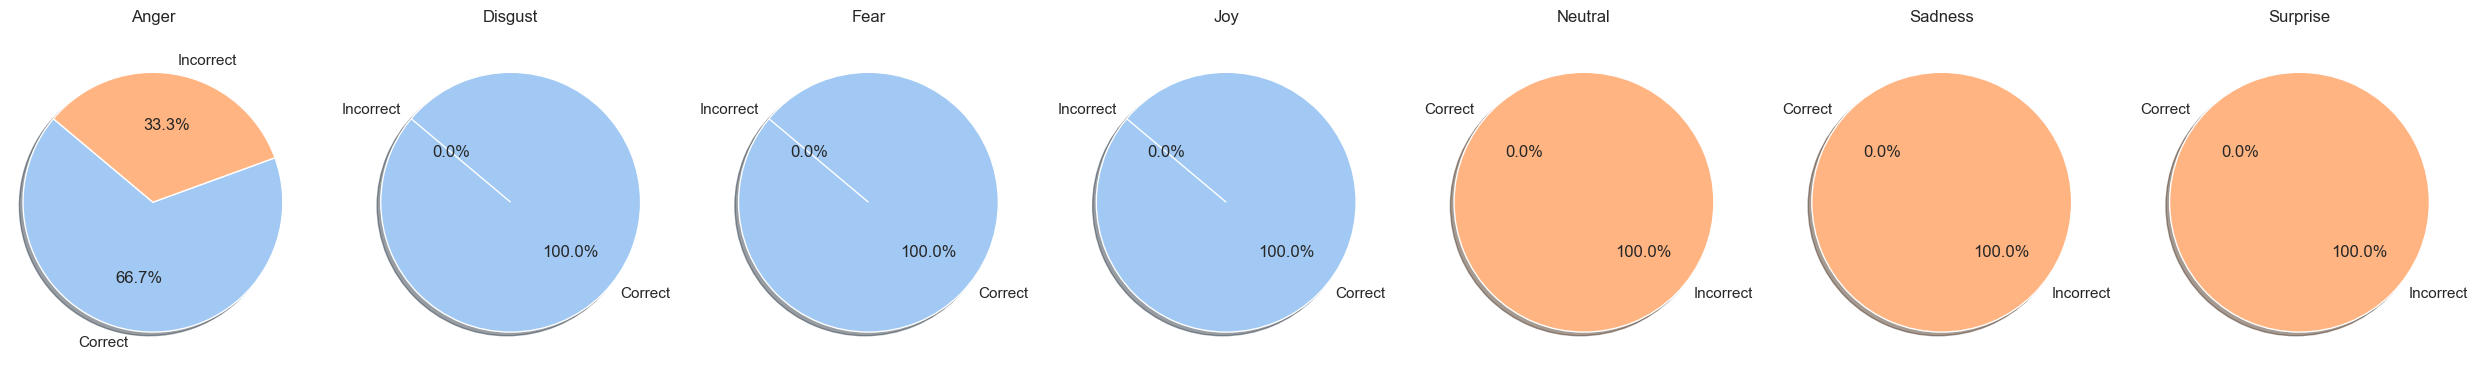

In [29]:
# Set beginning counters and dictionaries
correct = 0
incorrect = 0
emotions_correct = {}
emotions_incorrect = {}
total_emotions = {}

# Count number of emotions in golden_set
for emotion in golden_set['emotion']:
    if emotion not in total_emotions:
        total_emotions[emotion] = 1
    else:
        total_emotions[emotion] += 1

# Count emotions distilRoBERTa correctly and incorrectly identifies
for roberta_emotion, true_emotion in zip(golden_set['RoBERTa'], golden_set['emotion']):
    if roberta_emotion == true_emotion:
        correct += 1
        if roberta_emotion not in emotions_correct:
            emotions_correct[roberta_emotion] = 1
        else:
            emotions_correct[roberta_emotion] += 1
    else:
        incorrect += 1
        if roberta_emotion not in emotions_incorrect:
            emotions_incorrect[roberta_emotion] = 1
        else:
            emotions_incorrect[roberta_emotion] += 1
for emotion in total_emotions:
    if emotion not in emotions_correct:
        emotions_correct[emotion] = 0

# Print counters and dictionaries
print(f"Our DistilRoBERTa model correctly identified {correct} and got {incorrect} wrong.")
print(f"Total emotions in golden_set: {total_emotions}")
print(f"Emotions correctly identified: {emotions_correct}")
print(f"Emotions incorrectly identified: {emotions_incorrect}")

# Set the Seaborn style
sns.set(style="whitegrid")
colors = sns.color_palette('pastel')

# Define the emotions to plot
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Create subplots
fig, axs = plt.subplots(1, len(emotions), figsize=(25, 4))

for i, emotion in enumerate(emotions):
    sizes = [emotions_correct[emotion], total_emotions[emotion] - emotions_correct[emotion]]
    labels = 'Correct', 'Incorrect'
    axs[i].pie(sizes, labels=labels, colors=colors[0:2],
               autopct='%1.1f%%', shadow=True, startangle=140)
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[i].set_title(emotion.capitalize())

plt.tight_layout()
plt.show()

### Observations 

The DistilRoBERTa did well on 4 emotions : Anger, Disgust, Fear and Joy. From this information we decided to start an analysis of the the different files we created for these 4 emotions. 

## DistilBERT

Overall we already know that our DistilBERT model did not perform well but we wanted to see what he got right. 

Our DistilBERT model correctly identified 4 and got 38 wrong.
Total emotions in golden_set: {'anger': 6, 'disgust': 6, 'fear': 6, 'joy': 6, 'neutral': 6, 'sadness': 6, 'surprise': 6}
Emotions correctly identified: {'neutral': 4, 'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0}
Emotions incorrectly identified: {'joy': 15, 'neutral': 3, 'disgust': 10, 'sadness': 4, 'anger': 6}


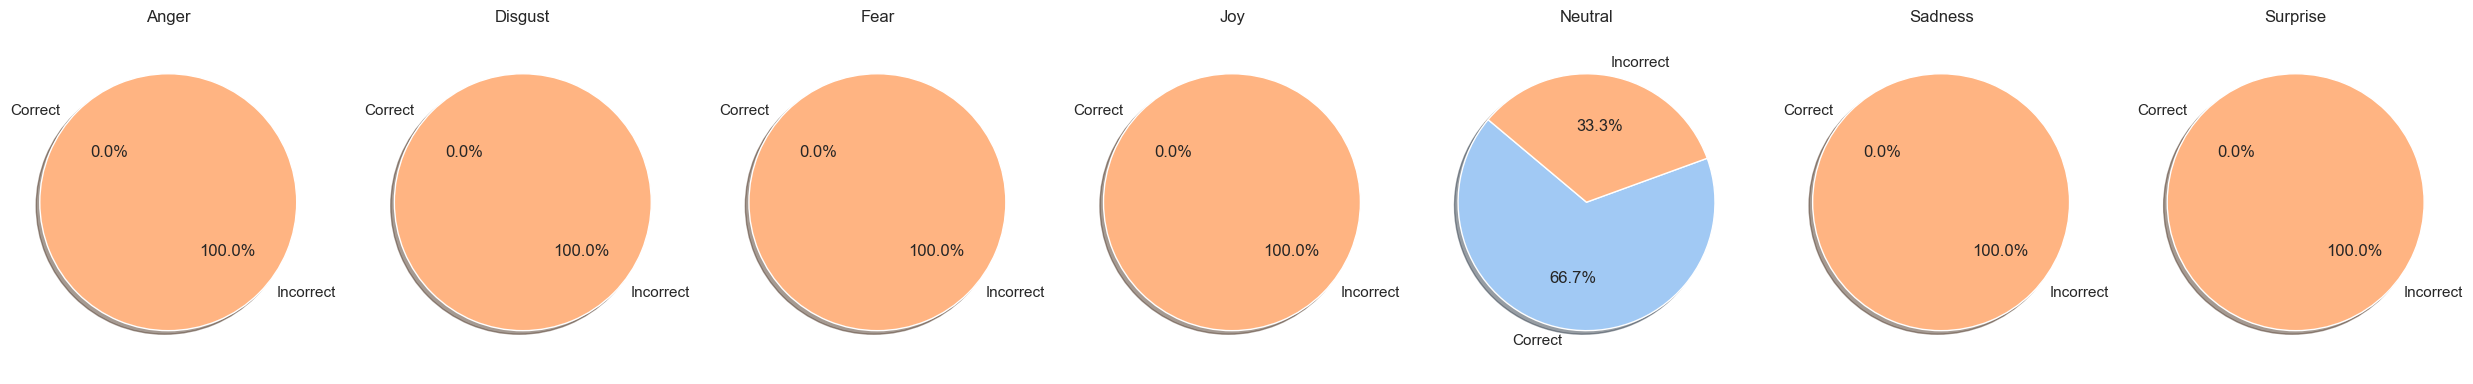

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set beginning counters and dictionaries
correct = 0
incorrect = 0
emotions_correct = {}
emotions_incorrect = {}
total_emotions = {}

# Count number of emotions in golden_set
for emotion in golden_set['emotion']:
    if emotion not in total_emotions:
        total_emotions[emotion] = 1
    else:
        total_emotions[emotion] += 1

# Count emotions distilRoBERTa correctly and incorrectly identifies
for bert_emotion, true_emotion in zip(golden_set['BERT'], golden_set['emotion']):
    if bert_emotion == true_emotion:
        correct += 1
        if bert_emotion not in emotions_correct:
            emotions_correct[bert_emotion] = 1
        else:
            emotions_correct[bert_emotion] += 1
    else:
        incorrect += 1
        if bert_emotion not in emotions_incorrect:
            emotions_incorrect[bert_emotion] = 1
        else:
            emotions_incorrect[bert_emotion] += 1
for emotion in total_emotions:
    if emotion not in emotions_correct:
        emotions_correct[emotion] = 0

# Print counters and dictionaries
print(f"Our DistilBERT model correctly identified {correct} and got {incorrect} wrong.")
print(f"Total emotions in golden_set: {total_emotions}")
print(f"Emotions correctly identified: {emotions_correct}")
print(f"Emotions incorrectly identified: {emotions_incorrect}")

# Set the Seaborn style
sns.set(style="whitegrid")
colors = sns.color_palette('pastel')

# Define the emotions to plot
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Create subplots
fig, axs = plt.subplots(1, len(emotions), figsize=(25, 4))

for i, emotion in enumerate(emotions):
    sizes = [emotions_correct[emotion], total_emotions[emotion] - emotions_correct[emotion]]
    labels = 'Correct', 'Incorrect'
    axs[i].pie(sizes, labels=labels, colors=colors[0:2],
               autopct='%1.1f%%', shadow=True, startangle=140)
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[i].set_title(emotion.capitalize())

plt.tight_layout()
plt.show()

### Observations 

The only emotion that was partially correctly identified actually came from the TextBlob library, not from our model. For DistilBERT, the key lies in having a better training set. With more time, it would be beneficial to label a portion of our data for training and then evaluate its performance. The model's poor performance in this case is likely due to the training data used, which wasn't the best fit for this specific task.

## Further analysis 

The next step of this project involved examining the comments categorized by each emotion. You can find the different insights gathered from this initial analysis in the other notebooks.